# 累積和法（変化点検知）


## 0.データ取得

In [ ]:
import pandas as pd
import numpy as np
from glob import glob
import pathlib
import os

In [ ]:
googledrive = True

In [ ]:
# ドライブのマウント
if googledrive:

    from google.colab import drive
    drive.mount('/content/drive/')
    # ここに成果物フォルダのパスを指定する
    %cd "/content/drive/MyDrive/AIQ2021_CoCreation_MaNiAC/"

pwd = pathlib.Path(".")
print("pwd:",pwd.resolve())
sorted([v for v in pwd.glob("*") if ".ipynb_checkpoints" not in str(v)])

Mounted at /content/drive/
/content/drive/.shortcut-targets-by-id/1R8RIgnShD3MN3kkS8rh6uzu1v6x_Pi9W/AIQ2021_CoCreation_MaNiAC
pwd: /content/drive/.shortcut-targets-by-id/1R8RIgnShD3MN3kkS8rh6uzu1v6x_Pi9W/AIQ2021_CoCreation_MaNiAC


[PosixPath('AutoEncoder_DEMO'),
 PosixPath('LICENSE'),
 PosixPath('README.ipynb'),
 PosixPath('dataset'),
 PosixPath('eda.ipynb'),
 PosixPath('fmt.ipynb'),
 PosixPath('github'),
 PosixPath('input'),
 PosixPath('matrix_profile.ipynb'),
 PosixPath('presentation'),
 PosixPath('sample_code'),
 PosixPath('事例紹介_関連文献'),
 PosixPath('報告資料')]

In [ ]:
INPUT_PATH = pwd/'input'/'currentdata'
current_file_list = sorted(INPUT_PATH.glob('*.csv'))
print(current_file_list)

[PosixPath('input/currentdata/current_day01.csv'), PosixPath('input/currentdata/current_day02.csv'), PosixPath('input/currentdata/current_day03.csv'), PosixPath('input/currentdata/current_day04.csv'), PosixPath('input/currentdata/current_day05.csv'), PosixPath('input/currentdata/current_day06.csv'), PosixPath('input/currentdata/current_day07.csv'), PosixPath('input/currentdata/current_day08.csv'), PosixPath('input/currentdata/current_day09.csv'), PosixPath('input/currentdata/current_day10.csv'), PosixPath('input/currentdata/current_day11.csv')]


In [ ]:
# 電流データをdf化

df_list = []
for i, file in enumerate(current_file_list):
    df_list.append(pd.read_csv(file,header=0, names=[f'time_day{i+1}',f'Current_day{i+1}']).fillna(0))

df_concat = pd.concat(df_list, axis=1)

df_concat.info()
df_concat.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 900 entries, 0 to 899
Data columns (total 22 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   time_day1      900 non-null    int64  
 1   Current_day1   900 non-null    float64
 2   time_day2      894 non-null    float64
 3   Current_day2   894 non-null    float64
 4   time_day3      900 non-null    int64  
 5   Current_day3   900 non-null    float64
 6   time_day4      900 non-null    int64  
 7   Current_day4   900 non-null    float64
 8   time_day5      900 non-null    int64  
 9   Current_day5   900 non-null    float64
 10  time_day6      900 non-null    int64  
 11  Current_day6   900 non-null    float64
 12  time_day7      900 non-null    int64  
 13  Current_day7   900 non-null    float64
 14  time_day8      900 non-null    int64  
 15  Current_day8   900 non-null    float64
 16  time_day9      900 non-null    int64  
 17  Current_day9   900 non-null    float64
 18  time_day10

,time_day1,Current_day1,time_day2,Current_day2,time_day3,Current_day3,time_day4,Current_day4,time_day5,Current_day5,time_day6,Current_day6,time_day7,Current_day7,time_day8,Current_day8,time_day9,Current_day9,time_day10,Current_day10,time_day11,Current_day11
0,0,0.0,0.0,0.0,0,0.0,0,0.0,0,0.0,0,0.0,0,0.0,0,0.0,0,0.0,0,0.0,0,0.0
1,58,0.0,60.0,0.0,60,0.0,63,0.0,60,0.0,58,0.0,59,0.0,62,0.0,59,0.0,58,0.0,59,0.0
2,118,0.0,118.0,0.0,120,0.0,120,0.0,118,0.0,118,0.0,117,0.0,138,0.0,117,0.0,119,0.0,118,0.0
3,176,0.0,178.0,0.0,178,0.0,178,0.0,178,0.0,176,0.0,177,0.0,177,0.0,177,0.0,178,0.0,178,0.0
4,236,0.0,237.0,0.0,238,0.0,239,0.0,236,0.0,236,0.0,235,0.0,235,0.0,237,0.0,236,0.0,237,0.0


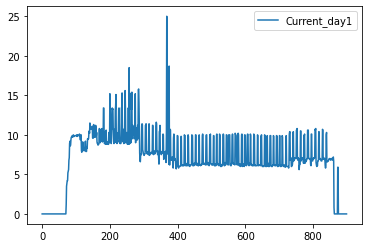

In [ ]:
# 電流データの可視化（1日）
day = 1
df_concat['Current_day'+str(day)].plot(x=df_concat['time_day'+str(day)],legend=True)

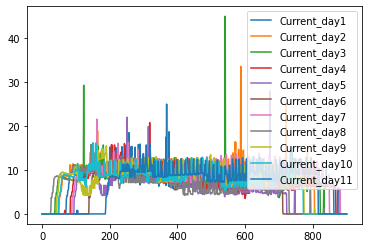

In [ ]:
# 電流データの可視化（全期間）
for x in range(len(current_file_list)):
    df_concat[f'Current_day{x+1}'].plot(x=df_concat[f'time_day{x+1}'],legend=True)

## 1.累積和法の実装

異常値を累積して、閾値を越えたら異常状態に入ったと判断する。

references:

https://deus-ex-machina-ism.com/?p=15392

https://qiita.com/ngayope330/items/d6951232b80662e831b1

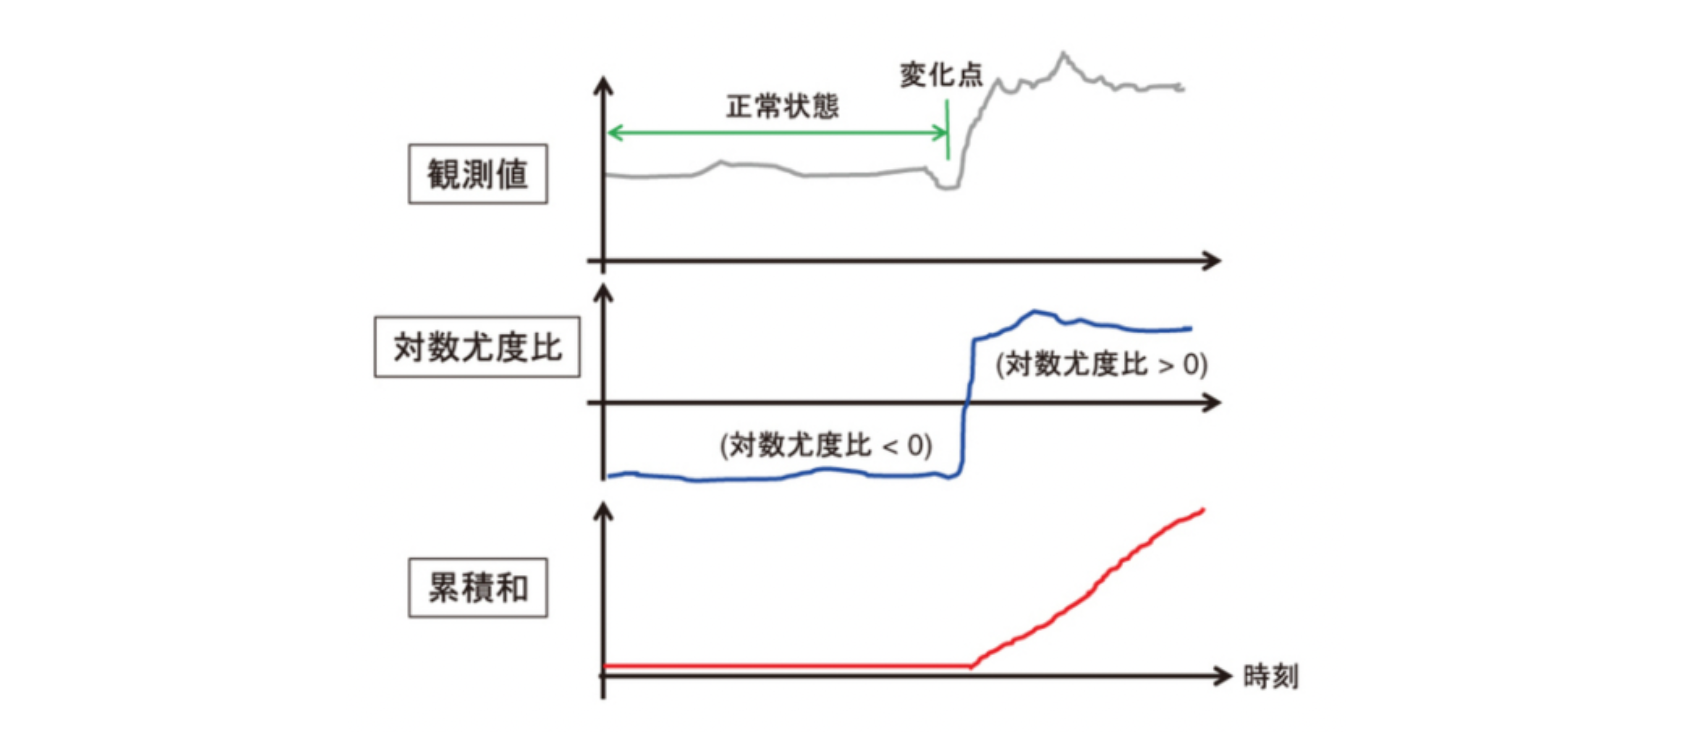

1日目の電流値は、朝から昼にかけて下がっている。

これを異常状態への遷移と仮定して変化点検知を試みる。

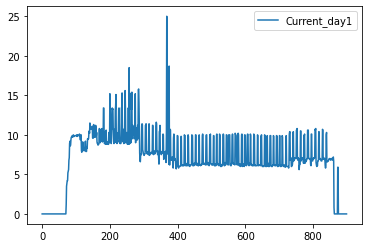

In [ ]:
# 電流データの可視化（1日）
day = 1
df_concat['Current_day'+str(day)].plot(x=df_concat['time_day'+str(day)],legend=True)

朝の電流値（10A付近）のデータを正常データとする。

In [ ]:
# 正常データの作成
day = 1
data =   df_concat['Current_day'+str(day)].values[80:]  #電流データを取得
#num = np.array([i for i in range(len(data))])   #標本番号を取得

In [ ]:
def fit_normal(data):

    # 正常時の平均,標準偏差を計算
    normal_interval = data
    mu = np.mean(normal_interval)
    std = np.std(normal_interval)

    print("mu:",round(mu,1),"std:",round(std,1))

    return mu, std

def test_cusum(data,mu,std,nu,th):

    # 変化度の計算
    change_score = (nu/std)*((data-mu+nu/2)/std)

    x_cusum = change_score.copy()
    for i in range(change_score.size - 1):
        x_cusum[i] = min(0, x_cusum[i])
        x_cusum[i+1] = x_cusum[i]+x_cusum[i+1]

    ind_anormal = np.sum(x_cusum > th)
    print("異常判定：", str(ind_anormal))

    plt.plot(range(data.size),data*50, color="gray")
    plt.plot(range(x_cusum.size),x_cusum)
    plt.axvline(x=ind_anormal,color="red",linestyle="--")
    plt.grid(True)
    plt.title("Result")
    plt.xlabel("Sample number")
    plt.ylabel("anormal_cusum")
    plt.show()


2A下がったら異常とする。

累積の変化スコアが-100を下回ったら、異常状態に入ったと判定する。

mu: 9.9 std: 1.4
異常判定： 346


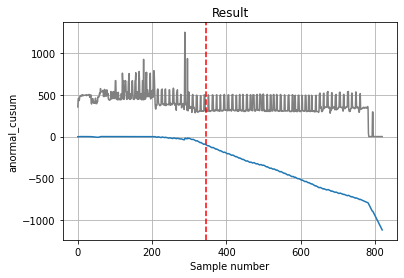

In [ ]:
# 異常とする幅を設定
nu = 2
# 正常データのフィッティング
mu, std = fit_normal(data[:150])
# 閾値設定
th = -100

test_cusum(data,mu,std,nu,th)